In [1]:
import os 
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-GPU-ff380879-d5b2-8469-da3d-71267d28a645/0/0"

n_epochs = 25

In [2]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb 

In [3]:
from pytorch_ood.model import WideResNet
from pytorch_ood.detector import EnergyBased, MaxSoftmax
from pytorch_ood.utils import OODMetrics, ToUnknown, ToRGB
from pytorch_ood.dataset.img import Textures, LSUNCrop, LSUNResize, TinyImageNetCrop, TinyImageNetResize
from torchvision.datasets import CIFAR10
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import Compose, ToPILImage, Normalize, ToTensor, Resize, ToPILImage
import torch 

def test(model):
    
    prep = Compose([
        ToRGB(),
        Resize([32,32]),
        ToTensor(),
        Normalize(
            std=[0.24705882352941176470, 0.24352941176470588235, 0.26156862745098039215], 
            mean=[0.49137254901960784313, 0.48235294117647058823, 0.44666666666666666666]), 
        ])

    metrics = [] 
    
    with torch.no_grad():
        model.eval()

        data_in = CIFAR10(root="/data_fast/kirchheim/datasets/", download=True, transform=prep, train=False)

        for Data_clz in [Textures, LSUNCrop, LSUNResize, TinyImageNetCrop, TinyImageNetResize]:
            ood_name = Data_clz.__name__

            data_out = Data_clz(root="/data_fast/kirchheim/datasets/", transform=prep, download=True, 
                                target_transform=ToUnknown())

            data_loader = DataLoader(data_in + data_out, batch_size=128, num_workers=10)

            # create detector
            softmax = MaxSoftmax(model)
            energy = EnergyBased(model)

            # evaluate
            metric_softmax = OODMetrics()
            metric_energy = OODMetrics()

            for x, y in data_loader:
                logits = model(x.cuda())
                metric_softmax.update(softmax.score(logits), y)
                metric_energy.update(energy.score(logits), y)

            # print(ood_name, metric_softmax.compute())

            m = metric_softmax.compute()
            m.update({
                "Dataset": ood_name,
                "Method": "Softmax"
            })
            metrics.append(m)
            
            m = metric_energy.compute()
            m.update({
                "Dataset": ood_name,
                "Method": "Energy"
            })
            metrics.append(m)
    
    model.train()
    
    return metrics

In [4]:
# create Neural Network
model = WideResNet(pretrained="cifar10-pt", num_classes=10).eval().cuda()
metrics = test(model)

Files already downloaded and verified


/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

In [1]:
import pandas as pd 

data = pd.DataFrame(metrics)
print((data.groupby(["Method"]).mean() * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]]
      .to_latex(float_format="%.2f"))

NameError: name 'metrics' is not defined

In [6]:
from pytorch_ood.model import WideResNet
from pytorch_ood.detector import EnergyBased, MaxSoftmax
from pytorch_ood.utils import OODMetrics
from pytorch_ood.dataset.img import Textures
from torchvision.datasets import CIFAR10 
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import Compose, ToPILImage, Normalize, ToTensor, Resize, ToPILImage
import torch 

from pytorch_ood.loss import OutlierExposureLoss
from torch.optim import SGD
from tqdm import tqdm

torch.manual_seed(10)

prep = Compose([
    ToPILImage(),
    Resize([32,32]),
    ToTensor(),
    Normalize(
        std=[0.24705882352941176470, 0.24352941176470588235, 0.26156862745098039215], 
        mean=[0.49137254901960784313, 0.48235294117647058823, 0.44666666666666666666]), 
    ])

mt = Compose([
    #ToPILImage(),
    Resize([32,32]),
    ToTensor(),
    Normalize(
        std=[0.24705882352941176470, 0.24352941176470588235, 0.26156862745098039215], 
        mean=[0.49137254901960784313, 0.48235294117647058823, 0.44666666666666666666]), 
    ])

# TODO: use 80,000?
x = torch.load("samples-c10.pt")[:80000]
gan_oe_data = torch.stack([prep(t) for t in x])
gan_oe_label = torch.ones(size=(len(x),)).long() * -1

data_in_train = CIFAR10(root="data/", download=True, transform=mt, target_transform=torch.tensor)
data_out_train = TensorDataset(gan_oe_data,gan_oe_label)
train_loader = DataLoader(data_in_train + data_out_train, batch_size=256, shuffle=True, num_workers=20)
      
# create Neural Network
model = WideResNet(pretrained="cifar10-pt", num_classes=10).cuda()
opti = SGD(model.parameters(), lr=0.001)

criterion = OutlierExposureLoss(alpha=0.5)

mav = 0.0
mavs = []

metrics_goe = []

for i in range(n_epochs):
    print(f"Epoch {i}")
    
    # train 
    model.train()
    bar = tqdm(train_loader)
    for x, y in bar:
        opti.zero_grad()
        y_hat = model(x.cuda())
        loss = criterion(y_hat, y.cuda())
        mav = 0.2 * loss.item() + 0.8 * mav
        mavs.append(mav)

        loss.backward()
        opti.step()
        bar.set_postfix({"loss": mav})
        
    print(80*"#")
    
    r = test(model)
    for entry in r:
        entry.update({"Epoch": i})
    
    metrics_goe += r

Files already downloaded and verified
Epoch 0


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.50it/s, loss=0.978]


################################################################################
Files already downloaded and verified
Epoch 1


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.51it/s, loss=0.754]


################################################################################
Files already downloaded and verified
Epoch 2


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.52it/s, loss=0.672]


################################################################################
Files already downloaded and verified
Epoch 3


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.688]


################################################################################
Files already downloaded and verified
Epoch 4


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.57it/s, loss=0.648]


################################################################################
Files already downloaded and verified
Epoch 5


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.58it/s, loss=0.637]


################################################################################
Files already downloaded and verified
Epoch 6


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.51it/s, loss=0.637]


################################################################################
Files already downloaded and verified
Epoch 7


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.52it/s, loss=0.646]


################################################################################
Files already downloaded and verified
Epoch 8


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.54it/s, loss=0.631]


################################################################################
Files already downloaded and verified
Epoch 9


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.644]


################################################################################
Files already downloaded and verified
Epoch 10


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.50it/s, loss=0.622]


################################################################################
Files already downloaded and verified
Epoch 11


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.56it/s, loss=0.622]


################################################################################
Files already downloaded and verified
Epoch 12


100%|████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.51it/s, loss=0.62]


################################################################################
Files already downloaded and verified
Epoch 13


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.54it/s, loss=0.645]


################################################################################
Files already downloaded and verified
Epoch 14


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.54it/s, loss=0.628]


################################################################################
Files already downloaded and verified
Epoch 15


100%|████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.55it/s, loss=0.62]


################################################################################
Files already downloaded and verified
Epoch 16


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.55it/s, loss=0.591]


################################################################################
Files already downloaded and verified
Epoch 17


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.56it/s, loss=0.624]


################################################################################
Files already downloaded and verified
Epoch 18


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.56it/s, loss=0.635]


################################################################################
Files already downloaded and verified
Epoch 19


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.55it/s, loss=0.612]


################################################################################
Files already downloaded and verified
Epoch 20


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.55it/s, loss=0.623]


################################################################################
Files already downloaded and verified
Epoch 21


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.609]


################################################################################
Files already downloaded and verified
Epoch 22


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.55it/s, loss=0.646]


################################################################################
Files already downloaded and verified
Epoch 23


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.52it/s, loss=0.643]


################################################################################
Files already downloaded and verified
Epoch 24


100%|████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.54it/s, loss=0.63]


################################################################################
Files already downloaded and verified


In [80]:
data = pd.DataFrame(metrics_goe)
tmp = data[data["Epoch"] == n_epochs -1]
print((tmp.groupby(["Method"]).mean() * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]]
      .to_latex(float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  FPR95TPR \\
Method  &        &          &           &           \\
\midrule
Energy  &  95.51 &    94.04 &     96.52 &     18.50 \\
Softmax &  95.54 &    94.20 &     96.54 &     18.31 \\
\bottomrule
\end{tabular}



<AxesSubplot:xlabel='Epoch', ylabel='AUROC'>

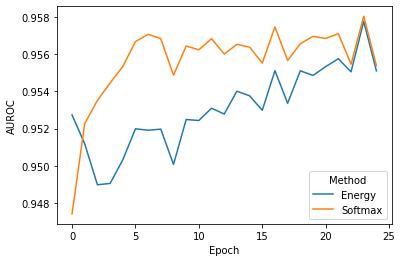

In [8]:
sb.lineplot(data=data.groupby(["Epoch", "Method"]).mean(), y="AUROC", x="Epoch", hue="Method")

# Noise Outlier Exposure

In [9]:
"""
Do it with uniformely distributed outlier samples 
"""
from pytorch_ood.model import WideResNet
from pytorch_ood.detector import EnergyBased, MaxSoftmax
from pytorch_ood.utils import OODMetrics
from pytorch_ood.dataset.img import Textures
from torchvision.datasets import CIFAR10 
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import Compose, ToPILImage, Normalize, ToTensor, Resize, ToPILImage
import torch 

from pytorch_ood.loss import OutlierExposureLoss
from torch.optim import SGD
from tqdm import tqdm

torch.manual_seed(10)


# TODO: use 80,000?
x = torch.randint(0, 255, size=(80000, 3, 32, 32), dtype=torch.uint8) #  torch.load("samples.pt")[:80000]
gan_oe_data = torch.stack([prep(t) for t in x])
gan_oe_label = torch.ones(size=(len(x),)).long() * -1

data_in_train = CIFAR10(root="data", download=True, transform=mt, target_transform=torch.tensor)
data_out_train = TensorDataset(gan_oe_data,gan_oe_label)
train_loader = DataLoader(data_in_train + data_out_train, batch_size=256, shuffle=True, num_workers=20)
      
# create Neural Network
model = WideResNet(pretrained="cifar10-pt", num_classes=10).cuda()
opti = SGD(model.parameters(), lr=0.001)

criterion = OutlierExposureLoss(alpha=0.5)

mav = 0.0
mavs = []

metrics_noise = []

for i in range(n_epochs):
    print(f"Epoch {i}")
    
    # train 
    model.train()
    bar = tqdm(train_loader)
    for x, y in bar:
        opti.zero_grad()
        y_hat = model(x.cuda())
        loss = criterion(y_hat, y.cuda())
        mav = 0.2 * loss.item() + 0.8 * mav
        mavs.append(mav)

        loss.backward()
        opti.step()
        bar.set_postfix({"loss": mav})
        
    print(80*"#")
    
    r = test(model)
    for entry in r:
        entry.update({"Epoch": i})
    
    metrics_noise += r

Files already downloaded and verified
Epoch 0


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.59it/s, loss=0.806]


################################################################################
Files already downloaded and verified


/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Epoch 1


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.58it/s, loss=0.767]


################################################################################
Files already downloaded and verified
Epoch 2


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.54it/s, loss=0.765]


################################################################################
Files already downloaded and verified
Epoch 3


100%|███████████████████████████████████████████████████| 508/508 [00:58<00:00,  8.61it/s, loss=0.745]


################################################################################
Files already downloaded and verified
Epoch 4


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.60it/s, loss=0.751]


################################################################################
Files already downloaded and verified
Epoch 5


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.729]


################################################################################
Files already downloaded and verified
Epoch 6


100%|████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.51it/s, loss=0.77]


################################################################################
Files already downloaded and verified
Epoch 7


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.61it/s, loss=0.735]


################################################################################
Files already downloaded and verified
Epoch 8


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.58it/s, loss=0.727]


################################################################################
Files already downloaded and verified
Epoch 9


100%|███████████████████████████████████████████████████| 508/508 [00:58<00:00,  8.63it/s, loss=0.728]


################################################################################
Files already downloaded and verified
Epoch 10


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.54it/s, loss=0.751]


################################################################################
Files already downloaded and verified
Epoch 11


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.57it/s, loss=0.735]


################################################################################
Files already downloaded and verified
Epoch 12


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.721]


################################################################################
Files already downloaded and verified
Epoch 13


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.59it/s, loss=0.705]


################################################################################
Files already downloaded and verified
Epoch 14


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.51it/s, loss=0.741]


################################################################################
Files already downloaded and verified
Epoch 15


100%|███████████████████████████████████████████████████| 508/508 [01:00<00:00,  8.45it/s, loss=0.721]


################################################################################
Files already downloaded and verified
Epoch 16


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.48it/s, loss=0.739]


################################################################################
Files already downloaded and verified
Epoch 17


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.47it/s, loss=0.726]


################################################################################
Files already downloaded and verified
Epoch 18


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.48it/s, loss=0.738]


################################################################################
Files already downloaded and verified
Epoch 19


100%|███████████████████████████████████████████████████| 508/508 [01:00<00:00,  8.45it/s, loss=0.741]


################################################################################
Files already downloaded and verified
Epoch 20


100%|████████████████████████████████████████████████████| 508/508 [01:00<00:00,  8.41it/s, loss=0.72]


################################################################################
Files already downloaded and verified
Epoch 21


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.50it/s, loss=0.709]


################################################################################
Files already downloaded and verified
Epoch 22


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.47it/s, loss=0.732]


################################################################################
Files already downloaded and verified
Epoch 23


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.52it/s, loss=0.725]


################################################################################
Files already downloaded and verified
Epoch 24


100%|███████████████████████████████████████████████████| 508/508 [01:00<00:00,  8.40it/s, loss=0.705]


################################################################################
Files already downloaded and verified


In [82]:
data = pd.DataFrame(metrics_noise)
tmp = data[data["Epoch"] == n_epochs - 1]
print((tmp.groupby(["Method"]).mean() * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]]
      .to_latex(float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  FPR95TPR \\
Method  &        &          &           &           \\
\midrule
Energy  &  97.36 &    96.32 &     97.95 &     11.54 \\
Softmax &  94.49 &    91.75 &     96.11 &     17.83 \\
\bottomrule
\end{tabular}



<AxesSubplot:xlabel='Epoch', ylabel='AUROC'>

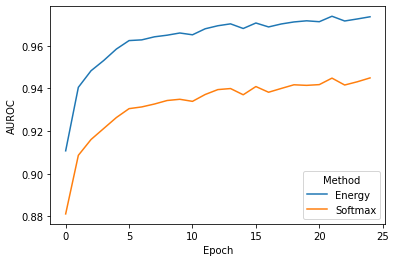

In [11]:
sb.lineplot(data=data.groupby(["Epoch", "Method"]).mean(), y="AUROC", x="Epoch", hue="Method")

# Real Outlier Exposure

In [12]:
"""
Do it with the usual (non-synthetic outliers)
"""
from pytorch_ood.model import WideResNet
from pytorch_ood.detector import EnergyBased, MaxSoftmax
from pytorch_ood.utils import OODMetrics
from pytorch_ood.dataset.img import Textures, TinyImages300k
from torchvision.datasets import CIFAR10 
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import Compose, ToPILImage, Normalize, ToTensor, Resize, ToPILImage
import torch 

from pytorch_ood.loss import OutlierExposureLoss
from torch.optim import SGD
from tqdm import tqdm

torch.manual_seed(10)

# prepare data 
# data_in_test = CIFAR100(root=".", download=True, transform=mt2, train=False)
# data_out_test = Textures(root=".", transform=mt2, download=True)
# test_loader = DataLoader(data_in_test + data_out_test, batch_size=512, num_workers=20)

# TODO: use 80,000?
# x = torch.randint(0, 255, size=(80000, 3, 32, 32), dtype=torch.uint8) #  torch.load("samples.pt")[:80000]
# gan_oe_data = torch.stack([mt(t) for t in x])
# gan_oe_label = torch.ones(size=(len(x),)).long() * -1

data_out_train = TinyImages300k(root="/data_fast/kirchheim/datasets/", transform=mt, download=True, 
                                target_transform=ToUnknown())

data_in_train = CIFAR10(root="data/", download=True, transform=mt)
train_loader = DataLoader(data_in_train + data_out_train, batch_size=256, shuffle=True, num_workers=20)
      
# create Neural Network
model = WideResNet(pretrained="cifar10-pt", num_classes=10).cuda()
opti = SGD(model.parameters(), lr=0.001)

criterion = OutlierExposureLoss(alpha=0.5)

mav = 0.0
mavs = []

metrics_oe = []

for i in range(n_epochs):
    print(f"Epoch {i}")
    
    # train 
    model.train()
    bar = tqdm(train_loader)
    for x, y in bar:
        opti.zero_grad()
        y_hat = model(x.cuda())
        loss = criterion(y_hat, y.cuda())
        mav = 0.2 * loss.item() + 0.8 * mav
        mavs.append(mav)

        loss.backward()
        opti.step()
        bar.set_postfix({"loss": mav})
        
    print(80*"#")
    
    r = test(model)
    for entry in r:
        entry.update({"Epoch": i})
    
    metrics_oe += r

Files already downloaded and verified
Epoch 0


100%|██████████████████████████████████████████████████| 1368/1368 [02:35<00:00,  8.79it/s, loss=1.26]


################################################################################
Files already downloaded and verified


/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Epoch 1


100%|██████████████████████████████████████████████████| 1368/1368 [02:36<00:00,  8.75it/s, loss=1.16]


################################################################################
Files already downloaded and verified
Epoch 2


100%|██████████████████████████████████████████████████| 1368/1368 [02:35<00:00,  8.79it/s, loss=1.14]


################################################################################
Files already downloaded and verified
Epoch 3


100%|███████████████████████████████████████████████████| 1368/1368 [02:35<00:00,  8.79it/s, loss=1.1]


################################################################################
Files already downloaded and verified
Epoch 4


100%|██████████████████████████████████████████████████| 1368/1368 [02:36<00:00,  8.76it/s, loss=1.11]


################################################################################
Files already downloaded and verified
Epoch 5


100%|██████████████████████████████████████████████████| 1368/1368 [02:35<00:00,  8.77it/s, loss=1.12]


################################################################################
Files already downloaded and verified
Epoch 6


100%|███████████████████████████████████████████████████| 1368/1368 [02:35<00:00,  8.77it/s, loss=1.1]


################################################################################
Files already downloaded and verified
Epoch 7


100%|███████████████████████████████████████████████████| 1368/1368 [02:36<00:00,  8.77it/s, loss=1.1]


################################################################################
Files already downloaded and verified
Epoch 8


100%|██████████████████████████████████████████████████| 1368/1368 [02:36<00:00,  8.75it/s, loss=1.09]


################################################################################
Files already downloaded and verified
Epoch 9


100%|███████████████████████████████████████████████████| 1368/1368 [02:36<00:00,  8.76it/s, loss=1.1]


################################################################################
Files already downloaded and verified
Epoch 10


100%|██████████████████████████████████████████████████| 1368/1368 [02:36<00:00,  8.76it/s, loss=1.08]


################################################################################
Files already downloaded and verified
Epoch 11


100%|██████████████████████████████████████████████████| 1368/1368 [02:35<00:00,  8.78it/s, loss=1.08]


################################################################################
Files already downloaded and verified
Epoch 12


100%|██████████████████████████████████████████████████| 1368/1368 [02:35<00:00,  8.78it/s, loss=1.09]


################################################################################
Files already downloaded and verified
Epoch 13


100%|██████████████████████████████████████████████████| 1368/1368 [02:36<00:00,  8.76it/s, loss=1.09]


################################################################################
Files already downloaded and verified
Epoch 14


100%|███████████████████████████████████████████████████| 1368/1368 [02:36<00:00,  8.75it/s, loss=1.1]


################################################################################
Files already downloaded and verified
Epoch 15


100%|███████████████████████████████████████████████████| 1368/1368 [02:35<00:00,  8.77it/s, loss=1.1]


################################################################################
Files already downloaded and verified
Epoch 16


100%|██████████████████████████████████████████████████| 1368/1368 [02:36<00:00,  8.76it/s, loss=1.09]


################################################################################
Files already downloaded and verified
Epoch 17


100%|██████████████████████████████████████████████████| 1368/1368 [02:35<00:00,  8.78it/s, loss=1.09]


################################################################################
Files already downloaded and verified
Epoch 18


100%|██████████████████████████████████████████████████| 1368/1368 [02:35<00:00,  8.77it/s, loss=1.08]


################################################################################
Files already downloaded and verified
Epoch 19


100%|██████████████████████████████████████████████████| 1368/1368 [02:36<00:00,  8.75it/s, loss=1.09]


################################################################################
Files already downloaded and verified
Epoch 20


100%|██████████████████████████████████████████████████| 1368/1368 [02:35<00:00,  8.78it/s, loss=1.07]


################################################################################
Files already downloaded and verified
Epoch 21


100%|██████████████████████████████████████████████████| 1368/1368 [02:36<00:00,  8.77it/s, loss=1.06]


################################################################################
Files already downloaded and verified
Epoch 22


100%|██████████████████████████████████████████████████| 1368/1368 [02:35<00:00,  8.77it/s, loss=1.09]


################################################################################
Files already downloaded and verified
Epoch 23


100%|██████████████████████████████████████████████████| 1368/1368 [02:36<00:00,  8.75it/s, loss=1.07]


################################################################################
Files already downloaded and verified
Epoch 24


100%|██████████████████████████████████████████████████| 1368/1368 [02:36<00:00,  8.75it/s, loss=1.06]


################################################################################
Files already downloaded and verified


In [83]:
data = pd.DataFrame(metrics_oe)
tmp = data[data["Epoch"] == n_epochs -1]

print((tmp.groupby(["Method"]).mean() * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]]
      .to_latex(float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  FPR95TPR \\
Method  &        &          &           &           \\
\midrule
Energy  &  98.63 &    97.91 &     98.99 &      5.88 \\
Softmax &  98.56 &    97.86 &     98.92 &      6.12 \\
\bottomrule
\end{tabular}



<AxesSubplot:xlabel='Epoch', ylabel='AUROC'>

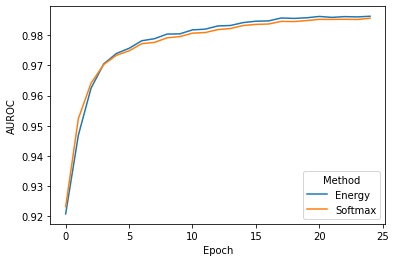

In [19]:
sb.lineplot(data=data.groupby(["Epoch", "Method"]).mean(), y="AUROC", x="Epoch", hue="Method")

# Other experiment

In [30]:
results = []

# 1.0, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0

for var in [0.0, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0]:
    data = np.load(f"cifar10/samples-{var}.npz")
    x = torch.tensor(data["x"])[:80000]

    # x = torch.load("samples/samples-{var}.pt")[:80000]
    gan_oe_data = torch.stack([prep(t) for t in x])
    gan_oe_label = torch.ones(size=(len(x),)).long() * -1

    data_in_train = CIFAR10(root="data/", download=True, transform=mt, target_transform=torch.tensor)
    data_out_train = TensorDataset(gan_oe_data,gan_oe_label)
    train_loader = DataLoader(data_in_train + data_out_train, batch_size=256, shuffle=True, num_workers=20)

    # create Neural Network
    model = WideResNet(pretrained="cifar10-pt", num_classes=10).cuda()
    opti = SGD(model.parameters(), lr=0.001)

    criterion = OutlierExposureLoss(alpha=0.5)

    mav = 0.0
    mavs = []

    for i in range(n_epochs):
        print(f"Epoch {i}")

        # train 
        model.train()
        bar = tqdm(train_loader)
        for x, y in bar:
            opti.zero_grad()
            y_hat = model(x.cuda())
            loss = criterion(y_hat, y.cuda())
            mav = 0.2 * loss.item() + 0.8 * mav
            mavs.append(mav)

            loss.backward()
            opti.step()
            bar.set_postfix({"loss": mav})
            
        
        r = test(model)
        for entry in r:
            entry.update({
                "Epoch": i,
                "Variance": var,
            })
        results += r 
        
        print(80*"#")
    

Files already downloaded and verified
Epoch 0


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.711]


Files already downloaded and verified


/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

################################################################################
Epoch 1


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.39it/s, loss=0.664]


Files already downloaded and verified
################################################################################
Epoch 2


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.648]


Files already downloaded and verified
################################################################################
Epoch 3


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.652]


Files already downloaded and verified
################################################################################
Epoch 4


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.611]


Files already downloaded and verified
################################################################################
Epoch 5


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.609]


Files already downloaded and verified
################################################################################
Epoch 6


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.619]


Files already downloaded and verified
################################################################################
Epoch 7


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.50it/s, loss=0.616]


Files already downloaded and verified
################################################################################
Epoch 8


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.50it/s, loss=0.581]


Files already downloaded and verified
################################################################################
Epoch 9


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.596]


Files already downloaded and verified
################################################################################
Epoch 10


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.587]


Files already downloaded and verified
################################################################################
Epoch 11


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.52it/s, loss=0.599]


Files already downloaded and verified
################################################################################
Epoch 12


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.50it/s, loss=0.592]


Files already downloaded and verified
################################################################################
Epoch 13


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.601]


Files already downloaded and verified
################################################################################
Epoch 14


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.609]


Files already downloaded and verified
################################################################################
Epoch 15


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.582]


Files already downloaded and verified
################################################################################
Epoch 16


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.609]


Files already downloaded and verified
################################################################################
Epoch 17


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.583]


Files already downloaded and verified
################################################################################
Epoch 18


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.578]


Files already downloaded and verified
################################################################################
Epoch 19


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.572]


Files already downloaded and verified
################################################################################
Epoch 20


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.44it/s, loss=0.593]


Files already downloaded and verified
################################################################################
Epoch 21


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.603]


Files already downloaded and verified
################################################################################
Epoch 22


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.598]


Files already downloaded and verified
################################################################################
Epoch 23


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.598]


Files already downloaded and verified
################################################################################
Epoch 24


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.597]


Files already downloaded and verified
################################################################################
Files already downloaded and verified
Epoch 0


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=1.36]


Files already downloaded and verified
################################################################################
Epoch 1


100%|█████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=1.1]


Files already downloaded and verified
################################################################################
Epoch 2


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=1.02]


Files already downloaded and verified
################################################################################
Epoch 3


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.916]


Files already downloaded and verified
################################################################################
Epoch 4


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.888]


Files already downloaded and verified
################################################################################
Epoch 5


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.87]


Files already downloaded and verified
################################################################################
Epoch 6


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.845]


Files already downloaded and verified
################################################################################
Epoch 7


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.799]


Files already downloaded and verified
################################################################################
Epoch 8


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.835]


Files already downloaded and verified
################################################################################
Epoch 9


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.82]


Files already downloaded and verified
################################################################################
Epoch 10


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.50it/s, loss=0.846]


Files already downloaded and verified
################################################################################
Epoch 11


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.808]


Files already downloaded and verified
################################################################################
Epoch 12


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.805]


Files already downloaded and verified
################################################################################
Epoch 13


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.788]


Files already downloaded and verified
################################################################################
Epoch 14


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.50it/s, loss=0.809]


Files already downloaded and verified
################################################################################
Epoch 15


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.806]


Files already downloaded and verified
################################################################################
Epoch 16


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.796]


Files already downloaded and verified
################################################################################
Epoch 17


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.50it/s, loss=0.783]


Files already downloaded and verified
################################################################################
Epoch 18


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.761]


Files already downloaded and verified
################################################################################
Epoch 19


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.74]


Files already downloaded and verified
################################################################################
Epoch 20


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.772]


Files already downloaded and verified
################################################################################
Epoch 21


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.44it/s, loss=0.779]


Files already downloaded and verified
################################################################################
Epoch 22


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.743]


Files already downloaded and verified
################################################################################
Epoch 23


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.744]


Files already downloaded and verified
################################################################################
Epoch 24


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.762]


Files already downloaded and verified
################################################################################
Files already downloaded and verified
Epoch 0


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.45it/s, loss=1.47]


Files already downloaded and verified
################################################################################
Epoch 1


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.45it/s, loss=1.17]


Files already downloaded and verified
################################################################################
Epoch 2


100%|█████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=1.1]


Files already downloaded and verified
################################################################################
Epoch 3


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=1.02]


Files already downloaded and verified
################################################################################
Epoch 4


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.978]


Files already downloaded and verified
################################################################################
Epoch 5


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.948]


Files already downloaded and verified
################################################################################
Epoch 6


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.93]


Files already downloaded and verified
################################################################################
Epoch 7


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.904]


Files already downloaded and verified
################################################################################
Epoch 8


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.44it/s, loss=0.905]


Files already downloaded and verified
################################################################################
Epoch 9


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.898]


Files already downloaded and verified
################################################################################
Epoch 10


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.861]


Files already downloaded and verified
################################################################################
Epoch 11


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.89]


Files already downloaded and verified
################################################################################
Epoch 12


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.38it/s, loss=0.905]


Files already downloaded and verified
################################################################################
Epoch 13


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.85]


Files already downloaded and verified
################################################################################
Epoch 14


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.843]


Files already downloaded and verified
################################################################################
Epoch 15


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.841]


Files already downloaded and verified
################################################################################
Epoch 16


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.829]


Files already downloaded and verified
################################################################################
Epoch 17


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.862]


Files already downloaded and verified
################################################################################
Epoch 18


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.849]


Files already downloaded and verified
################################################################################
Epoch 19


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.44it/s, loss=0.848]


Files already downloaded and verified
################################################################################
Epoch 20


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.858]


Files already downloaded and verified
################################################################################
Epoch 21


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.819]


Files already downloaded and verified
################################################################################
Epoch 22


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.808]


Files already downloaded and verified
################################################################################
Epoch 23


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.841]


Files already downloaded and verified
################################################################################
Epoch 24


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.41it/s, loss=0.839]


Files already downloaded and verified
################################################################################
Files already downloaded and verified
Epoch 0


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=1.45]


Files already downloaded and verified
################################################################################
Epoch 1


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.39it/s, loss=1.19]


Files already downloaded and verified
################################################################################
Epoch 2


100%|█████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=1.1]


Files already downloaded and verified
################################################################################
Epoch 3


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.45it/s, loss=1.01]


Files already downloaded and verified
################################################################################
Epoch 4


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.42it/s, loss=0.973]


Files already downloaded and verified
################################################################################
Epoch 5


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.926]


Files already downloaded and verified
################################################################################
Epoch 6


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.919]


Files already downloaded and verified
################################################################################
Epoch 7


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.903]


Files already downloaded and verified
################################################################################
Epoch 8


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.885]


Files already downloaded and verified
################################################################################
Epoch 9


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.879]


Files already downloaded and verified
################################################################################
Epoch 10


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.50it/s, loss=0.84]


Files already downloaded and verified
################################################################################
Epoch 11


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.86]


Files already downloaded and verified
################################################################################
Epoch 12


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.50it/s, loss=0.835]


Files already downloaded and verified
################################################################################
Epoch 13


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.43it/s, loss=0.871]


Files already downloaded and verified
################################################################################
Epoch 14


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.796]


Files already downloaded and verified
################################################################################
Epoch 15


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.841]


Files already downloaded and verified
################################################################################
Epoch 16


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.847]


Files already downloaded and verified
################################################################################
Epoch 17


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.854]


Files already downloaded and verified
################################################################################
Epoch 18


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.879]


Files already downloaded and verified
################################################################################
Epoch 19


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.809]


Files already downloaded and verified
################################################################################
Epoch 20


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.821]


Files already downloaded and verified
################################################################################
Epoch 21


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.39it/s, loss=0.831]


Files already downloaded and verified
################################################################################
Epoch 22


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.809]


Files already downloaded and verified
################################################################################
Epoch 23


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.791]


Files already downloaded and verified
################################################################################
Epoch 24


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.42it/s, loss=0.815]


Files already downloaded and verified
################################################################################
Files already downloaded and verified
Epoch 0


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=1.38]


Files already downloaded and verified
################################################################################
Epoch 1


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=1.15]


Files already downloaded and verified
################################################################################
Epoch 2


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=1.05]


Files already downloaded and verified
################################################################################
Epoch 3


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.51it/s, loss=0.968]


Files already downloaded and verified
################################################################################
Epoch 4


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.907]


Files already downloaded and verified
################################################################################
Epoch 5


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.50it/s, loss=0.895]


Files already downloaded and verified
################################################################################
Epoch 6


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.895]


Files already downloaded and verified
################################################################################
Epoch 7


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.878]


Files already downloaded and verified
################################################################################
Epoch 8


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.51it/s, loss=0.863]


Files already downloaded and verified
################################################################################
Epoch 9


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.41it/s, loss=0.832]


Files already downloaded and verified
################################################################################
Epoch 10


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.842]


Files already downloaded and verified
################################################################################
Epoch 11


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.834]


Files already downloaded and verified
################################################################################
Epoch 12


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.50it/s, loss=0.812]


Files already downloaded and verified
################################################################################
Epoch 13


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.50it/s, loss=0.796]


Files already downloaded and verified
################################################################################
Epoch 14


100%|███████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.50it/s, loss=0.816]


Files already downloaded and verified
################################################################################
Epoch 15


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.795]


Files already downloaded and verified
################################################################################
Epoch 16


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.825]


Files already downloaded and verified
################################################################################
Epoch 17


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.794]


Files already downloaded and verified
################################################################################
Epoch 18


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.797]


Files already downloaded and verified
################################################################################
Epoch 19


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.81]


Files already downloaded and verified
################################################################################
Epoch 20


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.815]


Files already downloaded and verified
################################################################################
Epoch 21


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.818]


Files already downloaded and verified
################################################################################
Epoch 22


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.809]


Files already downloaded and verified
################################################################################
Epoch 23


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.788]


Files already downloaded and verified
################################################################################
Epoch 24


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.808]


Files already downloaded and verified
################################################################################
Files already downloaded and verified
Epoch 0


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=1.37]


Files already downloaded and verified
################################################################################
Epoch 1


100%|█████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=1.1]


Files already downloaded and verified
################################################################################
Epoch 2


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=1.04]


Files already downloaded and verified
################################################################################
Epoch 3


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.952]


Files already downloaded and verified
################################################################################
Epoch 4


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.896]


Files already downloaded and verified
################################################################################
Epoch 5


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.893]


Files already downloaded and verified
################################################################################
Epoch 6


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.827]


Files already downloaded and verified
################################################################################
Epoch 7


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.50it/s, loss=0.856]


Files already downloaded and verified
################################################################################
Epoch 8


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.805]


Files already downloaded and verified
################################################################################
Epoch 9


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.825]


Files already downloaded and verified
################################################################################
Epoch 10


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.42it/s, loss=0.832]


Files already downloaded and verified
################################################################################
Epoch 11


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.41it/s, loss=0.821]


Files already downloaded and verified
################################################################################
Epoch 12


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.819]


Files already downloaded and verified
################################################################################
Epoch 13


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.41it/s, loss=0.762]


Files already downloaded and verified
################################################################################
Epoch 14


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.45it/s, loss=0.812]


Files already downloaded and verified
################################################################################
Epoch 15


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.801]


Files already downloaded and verified
################################################################################
Epoch 16


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.782]


Files already downloaded and verified
################################################################################
Epoch 17


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.49it/s, loss=0.783]


Files already downloaded and verified
################################################################################
Epoch 18


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.761]


Files already downloaded and verified
################################################################################
Epoch 19


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.41it/s, loss=0.786]


Files already downloaded and verified
################################################################################
Epoch 20


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.804]


Files already downloaded and verified
################################################################################
Epoch 21


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.774]


Files already downloaded and verified
################################################################################
Epoch 22


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.775]


Files already downloaded and verified
################################################################################
Epoch 23


100%|████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.44it/s, loss=0.77]


Files already downloaded and verified
################################################################################
Epoch 24


100%|███████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.46it/s, loss=0.803]


Files already downloaded and verified
################################################################################
Files already downloaded and verified
Epoch 0


100%|█████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.54it/s, loss=1.4]


Files already downloaded and verified
################################################################################
Epoch 1


100%|████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.53it/s, loss=1.08]


Files already downloaded and verified
################################################################################
Epoch 2


100%|████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.53it/s, loss=1.03]


Files already downloaded and verified
################################################################################
Epoch 3


100%|███████████████████████████████████████████████████| 508/508 [01:00<00:00,  8.46it/s, loss=0.926]


Files already downloaded and verified
################################################################################
Epoch 4


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.49it/s, loss=0.931]


Files already downloaded and verified
################################################################################
Epoch 5


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.49it/s, loss=0.905]


Files already downloaded and verified
################################################################################
Epoch 6


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.54it/s, loss=0.911]


Files already downloaded and verified
################################################################################
Epoch 7


100%|█████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.53it/s, loss=0.9]


Files already downloaded and verified
################################################################################
Epoch 8


100%|███████████████████████████████████████████████████| 508/508 [01:00<00:00,  8.46it/s, loss=0.909]


Files already downloaded and verified
################################################################################
Epoch 9


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.50it/s, loss=0.907]


Files already downloaded and verified
################################################################################
Epoch 10


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.50it/s, loss=0.881]


Files already downloaded and verified
################################################################################
Epoch 11


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.53it/s, loss=0.906]


Files already downloaded and verified
################################################################################
Epoch 12


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.48it/s, loss=0.864]


Files already downloaded and verified
################################################################################
Epoch 13


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.49it/s, loss=0.889]


Files already downloaded and verified
################################################################################
Epoch 14


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.55it/s, loss=0.863]


Files already downloaded and verified
################################################################################
Epoch 15


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.54it/s, loss=0.865]


Files already downloaded and verified
################################################################################
Epoch 16


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.52it/s, loss=0.864]


Files already downloaded and verified
################################################################################
Epoch 17


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.867]


Files already downloaded and verified
################################################################################
Epoch 18


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.872]


Files already downloaded and verified
################################################################################
Epoch 19


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.53it/s, loss=0.866]


Files already downloaded and verified
################################################################################
Epoch 20


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.54it/s, loss=0.871]


Files already downloaded and verified
################################################################################
Epoch 21


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.826]


Files already downloaded and verified
################################################################################
Epoch 22


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.857]


Files already downloaded and verified
################################################################################
Epoch 23


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.54it/s, loss=0.881]


Files already downloaded and verified
################################################################################
Epoch 24


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.55it/s, loss=0.842]


Files already downloaded and verified
################################################################################
Files already downloaded and verified
Epoch 0


100%|████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.53it/s, loss=1.27]


Files already downloaded and verified
################################################################################
Epoch 1


100%|████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.47it/s, loss=1.07]


Files already downloaded and verified
################################################################################
Epoch 2


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.48it/s, loss=0.926]


Files already downloaded and verified
################################################################################
Epoch 3


100%|████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.55it/s, loss=0.86]


Files already downloaded and verified
################################################################################
Epoch 4


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.54it/s, loss=0.862]


Files already downloaded and verified
################################################################################
Epoch 5


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.55it/s, loss=0.869]


Files already downloaded and verified
################################################################################
Epoch 6


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.824]


Files already downloaded and verified
################################################################################
Epoch 7


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.849]


Files already downloaded and verified
################################################################################
Epoch 8


100%|███████████████████████████████████████████████████| 508/508 [01:00<00:00,  8.46it/s, loss=0.862]


Files already downloaded and verified
################################################################################
Epoch 9


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.51it/s, loss=0.827]


Files already downloaded and verified
################################################################################
Epoch 10


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.59it/s, loss=0.856]


Files already downloaded and verified
################################################################################
Epoch 11


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.54it/s, loss=0.826]


Files already downloaded and verified
################################################################################
Epoch 12


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.814]


Files already downloaded and verified
################################################################################
Epoch 13


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.818]


Files already downloaded and verified
################################################################################
Epoch 14


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.54it/s, loss=0.837]


Files already downloaded and verified
################################################################################
Epoch 15


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.58it/s, loss=0.787]


Files already downloaded and verified
################################################################################
Epoch 16


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.821]


Files already downloaded and verified
################################################################################
Epoch 17


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.53it/s, loss=0.797]


Files already downloaded and verified
################################################################################
Epoch 18


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.802]


Files already downloaded and verified
################################################################################
Epoch 19


100%|████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.55it/s, loss=0.78]


Files already downloaded and verified
################################################################################
Epoch 20


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.55it/s, loss=0.809]


Files already downloaded and verified
################################################################################
Epoch 21


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.53it/s, loss=0.797]


Files already downloaded and verified
################################################################################
Epoch 22


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.49it/s, loss=0.807]


Files already downloaded and verified
################################################################################
Epoch 23


100%|████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.55it/s, loss=0.78]


Files already downloaded and verified
################################################################################
Epoch 24


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.53it/s, loss=0.793]


Files already downloaded and verified
################################################################################
Files already downloaded and verified
Epoch 0


100%|████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.54it/s, loss=1.27]


Files already downloaded and verified
################################################################################
Epoch 1


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.57it/s, loss=0.937]


Files already downloaded and verified
################################################################################
Epoch 2


100%|████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.59it/s, loss=0.88]


Files already downloaded and verified
################################################################################
Epoch 3


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.58it/s, loss=0.848]


Files already downloaded and verified
################################################################################
Epoch 4


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.59it/s, loss=0.833]


Files already downloaded and verified
################################################################################
Epoch 5


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.57it/s, loss=0.823]


Files already downloaded and verified
################################################################################
Epoch 6


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.789]


Files already downloaded and verified
################################################################################
Epoch 7


100%|█████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.59it/s, loss=0.8]


Files already downloaded and verified
################################################################################
Epoch 8


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.52it/s, loss=0.811]


Files already downloaded and verified
################################################################################
Epoch 9


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.57it/s, loss=0.801]


Files already downloaded and verified
################################################################################
Epoch 10


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.57it/s, loss=0.802]


Files already downloaded and verified
################################################################################
Epoch 11


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.54it/s, loss=0.794]


Files already downloaded and verified
################################################################################
Epoch 12


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.778]


Files already downloaded and verified
################################################################################
Epoch 13


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.55it/s, loss=0.766]


Files already downloaded and verified
################################################################################
Epoch 14


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.55it/s, loss=0.802]


Files already downloaded and verified
################################################################################
Epoch 15


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.792]


Files already downloaded and verified
################################################################################
Epoch 16


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.57it/s, loss=0.786]


Files already downloaded and verified
################################################################################
Epoch 17


100%|████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.51it/s, loss=0.75]


Files already downloaded and verified
################################################################################
Epoch 18


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.51it/s, loss=0.775]


Files already downloaded and verified
################################################################################
Epoch 19


100%|████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.47it/s, loss=0.76]


Files already downloaded and verified
################################################################################
Epoch 20


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.769]


Files already downloaded and verified
################################################################################
Epoch 21


100%|████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.55it/s, loss=0.76]


Files already downloaded and verified
################################################################################
Epoch 22


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.58it/s, loss=0.736]


Files already downloaded and verified
################################################################################
Epoch 23


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.57it/s, loss=0.779]


Files already downloaded and verified
################################################################################
Epoch 24


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.55it/s, loss=0.752]


Files already downloaded and verified
################################################################################
Files already downloaded and verified
Epoch 0


100%|████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.47it/s, loss=1.22]


Files already downloaded and verified
################################################################################
Epoch 1


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.54it/s, loss=0.922]


Files already downloaded and verified
################################################################################
Epoch 2


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.51it/s, loss=0.846]


Files already downloaded and verified
################################################################################
Epoch 3


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.811]


Files already downloaded and verified
################################################################################
Epoch 4


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.55it/s, loss=0.794]


Files already downloaded and verified
################################################################################
Epoch 5


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.58it/s, loss=0.786]


Files already downloaded and verified
################################################################################
Epoch 6


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.53it/s, loss=0.769]


Files already downloaded and verified
################################################################################
Epoch 7


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.783]


Files already downloaded and verified
################################################################################
Epoch 8


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.55it/s, loss=0.775]


Files already downloaded and verified
################################################################################
Epoch 9


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.53it/s, loss=0.762]


Files already downloaded and verified
################################################################################
Epoch 10


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.50it/s, loss=0.762]


Files already downloaded and verified
################################################################################
Epoch 11


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.52it/s, loss=0.742]


Files already downloaded and verified
################################################################################
Epoch 12


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.55it/s, loss=0.758]


Files already downloaded and verified
################################################################################
Epoch 13


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.52it/s, loss=0.763]


Files already downloaded and verified
################################################################################
Epoch 14


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.58it/s, loss=0.755]


Files already downloaded and verified
################################################################################
Epoch 15


100%|████████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.57it/s, loss=0.74]


Files already downloaded and verified
################################################################################
Epoch 16


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.53it/s, loss=0.765]


Files already downloaded and verified
################################################################################
Epoch 17


100%|███████████████████████████████████████████████████| 508/508 [01:00<00:00,  8.46it/s, loss=0.744]


Files already downloaded and verified
################################################################################
Epoch 18


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.49it/s, loss=0.757]


Files already downloaded and verified
################################################################################
Epoch 19


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.51it/s, loss=0.771]


Files already downloaded and verified
################################################################################
Epoch 20


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.47it/s, loss=0.754]


Files already downloaded and verified
################################################################################
Epoch 21


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.54it/s, loss=0.756]


Files already downloaded and verified
################################################################################
Epoch 22


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.56it/s, loss=0.746]


Files already downloaded and verified
################################################################################
Epoch 23


100%|███████████████████████████████████████████████████| 508/508 [00:59<00:00,  8.51it/s, loss=0.756]


Files already downloaded and verified
################################################################################
Epoch 24


100%|███████████████████████████████████████████████████| 508/508 [01:00<00:00,  8.47it/s, loss=0.751]


Files already downloaded and verified
################################################################################


In [43]:
tmpdf = pd.DataFrame(results)
tmpdf.to_csv("results/c10-auroc-vs-epoch-vs-variance.csv")

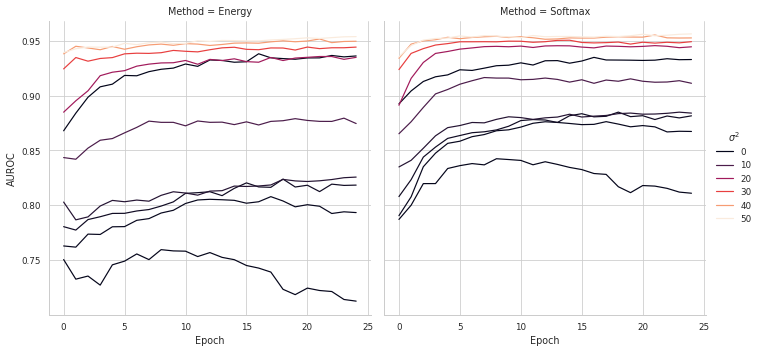

In [61]:
sb.set_style("whitegrid")
sb.set_context("paper")

from matplotlib import rcParams
rcParams['pgf.texsystem'] = "pdflatex"

tmpdf["$\sigma^2$"] = tmpdf["Variance"]

sb.relplot(data=tmpdf.groupby(["Epoch", "Method", "Variance"]).mean(), 
            x="Epoch", y="AUROC", hue="$\sigma^2$", palette="rocket", kind="line", col="Method")

plt.savefig("img/c10-auroc-vs-epoch-vs-variance.png", dpi=300)
plt.savefig("img/c10-auroc-vs-epoch-vs-variance.pgf", dpi=300)

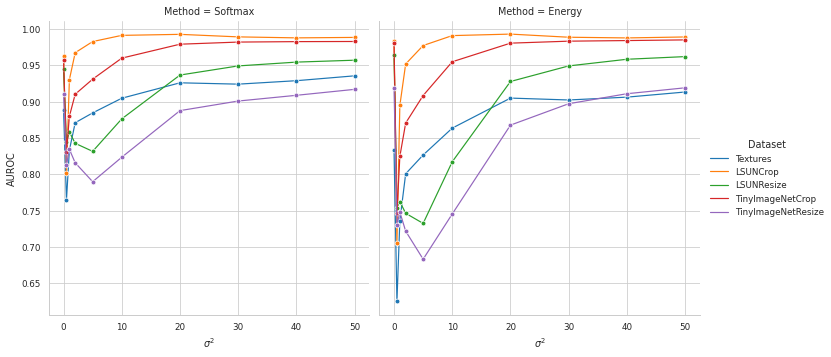

In [64]:
sb.relplot(data=tmpdf[tmpdf["Epoch"] == 24], 
            x="$\sigma^2$", y="AUROC", kind="line", col="Method", hue="Dataset", marker="o")

plt.savefig("img/c10-auroc-vs-variance.png", dpi=300)
plt.savefig("img/c10-auroc-vs-variance.pgf", dpi=300)

In [33]:

tmpdf.groupby(["Epoch", "Method", "Variance"]).mean()

AUROC   AUPR-IN  AUPR-OUT  ACC95TPR  FPR95TPR
Epoch Method  Variance                                                  
0     Energy  0.0       0.867851  0.831112  0.889360  0.731984   0.43980
              0.5       0.750507  0.729155  0.774432  0.601787   0.69448
              1.0       0.762882  0.737570  0.782122  0.611229   0.67578
              2.0       0.780458  0.755620  0.795922  0.629167   0.64088
              5.0       0.802884  0.780730  0.813577  0.650680   0.59966
...                          ...       ...       ...       ...       ...
24    Softmax 10.0      0.911178  0.888301  0.917226  0.790205   0.34750
              20.0      0.944412  0.926199  0.955047  0.858592   0.21648
              30.0      0.949081  0.932628  0.959929  0.866235   0.20208
              40.0      0.952508  0.937975  0.962723  0.872884   0.19080
              50.0      0.956178  0.942074  0.966194  0.880872   0.17624

[500 rows x 5 columns]

In [66]:
data = np.load(f"samples-c10.npz")
x = torch.tensor(data["x"])
x.shape

torch.Size([10000000, 3, 32, 32])

In [67]:
torch.manual_seed(10)

# TODO: use 80,000?
data = np.load(f"samples-c10.npz")

metrics_l = []
    
for l in [100, 1000, 10000, 20000, 50000, 100000]:
    xn = x[:l]
    gan_oe_data = torch.stack([prep(t) for t in xn])
    gan_oe_label = torch.ones(size=(len(xn),)).long() * -1

    data_in_train = CIFAR10(root="data/", download=True, transform=mt, target_transform=torch.tensor)
    data_out_train = TensorDataset(gan_oe_data,gan_oe_label)
    train_loader = DataLoader(data_in_train + data_out_train, batch_size=256, shuffle=True, num_workers=20)

    # create Neural Network
    model = WideResNet(pretrained="cifar10-pt", num_classes=10).cuda()
    opti = SGD(model.parameters(), lr=0.001)

    criterion = OutlierExposureLoss(alpha=0.5)

    mav = 0.0
    mavs = []

    for i in range(n_epochs):
        print(f"Epoch {i}")

        # train 
        model.train()
        bar = tqdm(train_loader)
        for x, y in bar:
            opti.zero_grad()
            y_hat = model(x.cuda())
            loss = criterion(y_hat, y.cuda())
            mav = 0.2 * loss.item() + 0.8 * mav
            mavs.append(mav)

            loss.backward()
            opti.step()
            bar.set_postfix({"loss": mav})

        print(80*"#")

        r = test(model)
        for entry in r:
            entry.update({
                "Epoch": i,
                "Length": l
            })

        metrics_l += r

Files already downloaded and verified
Epoch 0


100%|████████████████████████████| 196/196 [00:38<00:00,  5.09it/s, loss=0.051]


################################################################################
Files already downloaded and verified


/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Epoch 1


100%|███████████████████████████| 196/196 [00:40<00:00,  4.86it/s, loss=0.0416]


################################################################################
Files already downloaded and verified
Epoch 2


100%|███████████████████████████| 196/196 [00:39<00:00,  5.01it/s, loss=0.0419]


################################################################################
Files already downloaded and verified
Epoch 3


100%|███████████████████████████| 196/196 [00:38<00:00,  5.10it/s, loss=0.0277]


################################################################################
Files already downloaded and verified
Epoch 4


100%|███████████████████████████| 196/196 [00:38<00:00,  5.06it/s, loss=0.0206]


################################################################################
Files already downloaded and verified
Epoch 5


100%|███████████████████████████| 196/196 [00:41<00:00,  4.71it/s, loss=0.0288]


################################################################################
Files already downloaded and verified
Epoch 6


100%|███████████████████████████| 196/196 [00:39<00:00,  4.98it/s, loss=0.0185]


################################################################################
Files already downloaded and verified
Epoch 7


100%|███████████████████████████| 196/196 [00:39<00:00,  5.02it/s, loss=0.0291]


################################################################################
Files already downloaded and verified
Epoch 8


100%|███████████████████████████| 196/196 [00:38<00:00,  5.07it/s, loss=0.0252]


################################################################################
Files already downloaded and verified
Epoch 9


100%|████████████████████████████| 196/196 [00:40<00:00,  4.80it/s, loss=0.021]


################################################################################
Files already downloaded and verified
Epoch 10


100%|███████████████████████████| 196/196 [00:41<00:00,  4.74it/s, loss=0.0269]


################################################################################
Files already downloaded and verified
Epoch 11


100%|████████████████████████████| 196/196 [00:40<00:00,  4.83it/s, loss=0.019]


################################################################################
Files already downloaded and verified
Epoch 12


100%|████████████████████████████| 196/196 [00:41<00:00,  4.74it/s, loss=0.025]


################################################################################
Files already downloaded and verified
Epoch 13


100%|███████████████████████████| 196/196 [00:41<00:00,  4.77it/s, loss=0.0256]


################################################################################
Files already downloaded and verified
Epoch 14


100%|███████████████████████████| 196/196 [00:40<00:00,  4.85it/s, loss=0.0276]


################################################################################
Files already downloaded and verified
Epoch 15


100%|███████████████████████████| 196/196 [00:40<00:00,  4.82it/s, loss=0.0158]


################################################################################
Files already downloaded and verified
Epoch 16


100%|███████████████████████████| 196/196 [00:40<00:00,  4.83it/s, loss=0.0155]


################################################################################
Files already downloaded and verified
Epoch 17


100%|████████████████████████████| 196/196 [00:40<00:00,  4.83it/s, loss=0.024]


################################################################################
Files already downloaded and verified
Epoch 18


100%|███████████████████████████| 196/196 [00:40<00:00,  4.82it/s, loss=0.0183]


################################################################################
Files already downloaded and verified
Epoch 19


100%|███████████████████████████| 196/196 [00:41<00:00,  4.76it/s, loss=0.0147]


################################################################################
Files already downloaded and verified
Epoch 20


100%|███████████████████████████| 196/196 [00:40<00:00,  4.80it/s, loss=0.0183]


################################################################################
Files already downloaded and verified
Epoch 21


100%|███████████████████████████| 196/196 [00:40<00:00,  4.83it/s, loss=0.0147]


################################################################################
Files already downloaded and verified
Epoch 22


100%|███████████████████████████| 196/196 [00:38<00:00,  5.06it/s, loss=0.0173]


################################################################################
Files already downloaded and verified
Epoch 23


100%|████████████████████████████| 196/196 [00:38<00:00,  5.10it/s, loss=0.017]


################################################################################
Files already downloaded and verified
Epoch 24


100%|███████████████████████████| 196/196 [00:38<00:00,  5.08it/s, loss=0.0233]


################################################################################
Files already downloaded and verified
Files already downloaded and verified
Epoch 0


100%|████████████████████████████| 197/197 [00:24<00:00,  8.12it/s, loss=0.045]


################################################################################
Files already downloaded and verified
Epoch 1


100%|███████████████████████████| 197/197 [00:24<00:00,  8.11it/s, loss=0.0278]


################################################################################
Files already downloaded and verified
Epoch 2


100%|███████████████████████████| 197/197 [00:24<00:00,  8.10it/s, loss=0.0353]


################################################################################
Files already downloaded and verified
Epoch 3


100%|█████████████████████████████| 197/197 [00:24<00:00,  8.10it/s, loss=0.16]


################################################################################
Files already downloaded and verified
Epoch 4


100%|███████████████████████████| 197/197 [00:24<00:00,  8.14it/s, loss=0.0265]


################################################################################
Files already downloaded and verified
Epoch 5


100%|████████████████████████████| 197/197 [00:24<00:00,  8.12it/s, loss=0.114]


################################################################################
Files already downloaded and verified
Epoch 6


100%|███████████████████████████| 197/197 [00:24<00:00,  8.15it/s, loss=0.0287]


################################################################################
Files already downloaded and verified
Epoch 7


100%|███████████████████████████| 197/197 [00:24<00:00,  8.05it/s, loss=0.0229]


################################################################################
Files already downloaded and verified
Epoch 8


100%|███████████████████████████| 197/197 [00:24<00:00,  8.16it/s, loss=0.0286]


################################################################################
Files already downloaded and verified
Epoch 9


100%|████████████████████████████| 197/197 [00:24<00:00,  8.11it/s, loss=0.153]


################################################################################
Files already downloaded and verified
Epoch 10


100%|████████████████████████████| 197/197 [00:24<00:00,  8.05it/s, loss=0.022]


################################################################################
Files already downloaded and verified
Epoch 11


100%|███████████████████████████| 197/197 [00:24<00:00,  8.09it/s, loss=0.0233]


################################################################################
Files already downloaded and verified
Epoch 12


100%|████████████████████████████| 197/197 [00:24<00:00,  8.07it/s, loss=0.196]


################################################################################
Files already downloaded and verified
Epoch 13


100%|███████████████████████████| 197/197 [00:24<00:00,  8.11it/s, loss=0.0162]


################################################################################
Files already downloaded and verified
Epoch 14


100%|███████████████████████████| 197/197 [00:24<00:00,  7.97it/s, loss=0.0237]


################################################################################
Files already downloaded and verified
Epoch 15


100%|████████████████████████████| 197/197 [00:24<00:00,  8.09it/s, loss=0.245]


################################################################################
Files already downloaded and verified
Epoch 16


100%|███████████████████████████| 197/197 [00:24<00:00,  8.10it/s, loss=0.0774]


################################################################################
Files already downloaded and verified
Epoch 17


100%|████████████████████████████| 197/197 [00:24<00:00,  8.12it/s, loss=0.205]


################################################################################
Files already downloaded and verified
Epoch 18


100%|███████████████████████████| 197/197 [00:24<00:00,  7.95it/s, loss=0.0879]


################################################################################
Files already downloaded and verified
Epoch 19


100%|████████████████████████████| 197/197 [00:24<00:00,  8.11it/s, loss=0.149]


################################################################################
Files already downloaded and verified
Epoch 20


100%|███████████████████████████| 197/197 [00:24<00:00,  8.09it/s, loss=0.0324]


################################################################################
Files already downloaded and verified
Epoch 21


100%|███████████████████████████| 197/197 [00:24<00:00,  8.16it/s, loss=0.0284]


################################################################################
Files already downloaded and verified
Epoch 22


100%|███████████████████████████| 197/197 [00:24<00:00,  8.14it/s, loss=0.0969]


################################################################################
Files already downloaded and verified
Epoch 23


100%|███████████████████████████| 197/197 [00:24<00:00,  7.96it/s, loss=0.0568]


################################################################################
Files already downloaded and verified
Epoch 24


100%|████████████████████████████| 197/197 [00:24<00:00,  8.13it/s, loss=0.129]


################################################################################
Files already downloaded and verified
Files already downloaded and verified
Epoch 0


100%|███████████████████████████| 196/196 [00:23<00:00,  8.22it/s, loss=0.0561]


################################################################################
Files already downloaded and verified
Epoch 1


100%|███████████████████████████| 196/196 [00:23<00:00,  8.18it/s, loss=0.0285]


################################################################################
Files already downloaded and verified
Epoch 2


100%|███████████████████████████| 196/196 [00:23<00:00,  8.24it/s, loss=0.0318]


################################################################################
Files already downloaded and verified
Epoch 3


100%|███████████████████████████| 196/196 [00:23<00:00,  8.17it/s, loss=0.0233]


################################################################################
Files already downloaded and verified
Epoch 4


100%|███████████████████████████| 196/196 [00:23<00:00,  8.23it/s, loss=0.0212]


################################################################################
Files already downloaded and verified
Epoch 5


100%|███████████████████████████| 196/196 [00:23<00:00,  8.24it/s, loss=0.0179]


################################################################################
Files already downloaded and verified
Epoch 6


100%|███████████████████████████| 196/196 [00:23<00:00,  8.21it/s, loss=0.0173]


################################################################################
Files already downloaded and verified
Epoch 7


100%|███████████████████████████| 196/196 [00:23<00:00,  8.23it/s, loss=0.0205]


################################################################################
Files already downloaded and verified
Epoch 8


100%|███████████████████████████| 196/196 [00:23<00:00,  8.24it/s, loss=0.0177]


################################################################################
Files already downloaded and verified
Epoch 9


100%|███████████████████████████| 196/196 [00:23<00:00,  8.20it/s, loss=0.0198]


################################################################################
Files already downloaded and verified
Epoch 10


100%|████████████████████████████| 196/196 [00:23<00:00,  8.21it/s, loss=0.015]


################################################################################
Files already downloaded and verified
Epoch 11


100%|███████████████████████████| 196/196 [00:23<00:00,  8.17it/s, loss=0.0171]


################################################################################
Files already downloaded and verified
Epoch 12


100%|███████████████████████████| 196/196 [00:24<00:00,  8.10it/s, loss=0.0142]


################################################################################
Files already downloaded and verified
Epoch 13


100%|███████████████████████████| 196/196 [00:24<00:00,  8.14it/s, loss=0.0158]


################################################################################
Files already downloaded and verified
Epoch 14


100%|███████████████████████████| 196/196 [00:23<00:00,  8.19it/s, loss=0.0148]


################################################################################
Files already downloaded and verified
Epoch 15


100%|███████████████████████████| 196/196 [00:23<00:00,  8.18it/s, loss=0.0108]


################################################################################
Files already downloaded and verified
Epoch 16


100%|████████████████████████████| 196/196 [00:23<00:00,  8.20it/s, loss=0.014]


################################################################################
Files already downloaded and verified
Epoch 17


100%|███████████████████████████| 196/196 [00:23<00:00,  8.20it/s, loss=0.0124]


################################################################################
Files already downloaded and verified
Epoch 18


100%|███████████████████████████| 196/196 [00:24<00:00,  8.10it/s, loss=0.0199]


################################################################################
Files already downloaded and verified
Epoch 19


100%|███████████████████████████| 196/196 [00:23<00:00,  8.22it/s, loss=0.0112]


################################################################################
Files already downloaded and verified
Epoch 20


100%|███████████████████████████| 196/196 [00:23<00:00,  8.24it/s, loss=0.0103]


################################################################################
Files already downloaded and verified
Epoch 21


100%|███████████████████████████| 196/196 [00:24<00:00,  8.14it/s, loss=0.0115]


################################################################################
Files already downloaded and verified
Epoch 22


100%|███████████████████████████| 196/196 [00:23<00:00,  8.20it/s, loss=0.0157]


################################################################################
Files already downloaded and verified
Epoch 23


100%|███████████████████████████| 196/196 [00:23<00:00,  8.21it/s, loss=0.0102]


################################################################################
Files already downloaded and verified
Epoch 24


100%|████████████████████████████| 196/196 [00:24<00:00,  8.09it/s, loss=0.021]


################################################################################
Files already downloaded and verified
Files already downloaded and verified
Epoch 0


100%|███████████████████████████| 196/196 [00:24<00:00,  8.06it/s, loss=0.0443]


################################################################################
Files already downloaded and verified
Epoch 1


100%|███████████████████████████| 196/196 [00:24<00:00,  8.10it/s, loss=0.0414]


################################################################################
Files already downloaded and verified
Epoch 2


100%|████████████████████████████| 196/196 [00:24<00:00,  7.98it/s, loss=0.024]


################################################################################
Files already downloaded and verified
Epoch 3


100%|███████████████████████████| 196/196 [00:24<00:00,  8.09it/s, loss=0.0201]


################################################################################
Files already downloaded and verified
Epoch 4


100%|███████████████████████████| 196/196 [00:24<00:00,  8.15it/s, loss=0.0261]


################################################################################
Files already downloaded and verified
Epoch 5


100%|███████████████████████████| 196/196 [00:24<00:00,  8.08it/s, loss=0.0223]


################################################################################
Files already downloaded and verified
Epoch 6


100%|███████████████████████████| 196/196 [00:23<00:00,  8.17it/s, loss=0.0285]


################################################################################
Files already downloaded and verified
Epoch 7


100%|███████████████████████████| 196/196 [00:23<00:00,  8.17it/s, loss=0.0343]


################################################################################
Files already downloaded and verified
Epoch 8


100%|███████████████████████████| 196/196 [00:23<00:00,  8.21it/s, loss=0.0181]


################################################################################
Files already downloaded and verified
Epoch 9


100%|███████████████████████████| 196/196 [00:23<00:00,  8.18it/s, loss=0.0193]


################################################################################
Files already downloaded and verified
Epoch 10


100%|███████████████████████████| 196/196 [00:24<00:00,  8.03it/s, loss=0.0213]


################################################################################
Files already downloaded and verified
Epoch 11


100%|███████████████████████████| 196/196 [00:24<00:00,  8.11it/s, loss=0.0194]


################################################################################
Files already downloaded and verified
Epoch 12


100%|███████████████████████████| 196/196 [00:24<00:00,  8.16it/s, loss=0.0192]


################################################################################
Files already downloaded and verified
Epoch 13


100%|███████████████████████████| 196/196 [00:24<00:00,  8.16it/s, loss=0.0274]


################################################################################
Files already downloaded and verified
Epoch 14


100%|███████████████████████████| 196/196 [00:24<00:00,  7.99it/s, loss=0.0186]


################################################################################
Files already downloaded and verified
Epoch 15


100%|███████████████████████████| 196/196 [00:24<00:00,  8.16it/s, loss=0.0169]


################################################################################
Files already downloaded and verified
Epoch 16


100%|███████████████████████████| 196/196 [00:24<00:00,  8.17it/s, loss=0.0122]


################################################################################
Files already downloaded and verified
Epoch 17


100%|███████████████████████████| 196/196 [00:24<00:00,  8.05it/s, loss=0.0171]


################################################################################
Files already downloaded and verified
Epoch 18


100%|███████████████████████████| 196/196 [00:23<00:00,  8.17it/s, loss=0.0151]


################################################################################
Files already downloaded and verified
Epoch 19


100%|███████████████████████████| 196/196 [00:24<00:00,  8.16it/s, loss=0.0214]


################################################################################
Files already downloaded and verified
Epoch 20


100%|████████████████████████████| 196/196 [00:23<00:00,  8.18it/s, loss=0.013]


################################################################################
Files already downloaded and verified
Epoch 21


100%|███████████████████████████| 196/196 [00:24<00:00,  7.98it/s, loss=0.0166]


################################################################################
Files already downloaded and verified
Epoch 22


100%|███████████████████████████| 196/196 [00:24<00:00,  8.08it/s, loss=0.0162]


################################################################################
Files already downloaded and verified
Epoch 23


100%|███████████████████████████| 196/196 [00:24<00:00,  8.12it/s, loss=0.0147]


################################################################################
Files already downloaded and verified
Epoch 24


100%|███████████████████████████| 196/196 [00:24<00:00,  8.05it/s, loss=0.0123]


################################################################################
Files already downloaded and verified
Files already downloaded and verified
Epoch 0


100%|███████████████████████████| 196/196 [00:24<00:00,  8.05it/s, loss=0.0537]


################################################################################
Files already downloaded and verified
Epoch 1


100%|███████████████████████████| 196/196 [00:24<00:00,  8.15it/s, loss=0.0472]


################################################################################
Files already downloaded and verified
Epoch 2


100%|███████████████████████████| 196/196 [00:24<00:00,  8.11it/s, loss=0.0278]


################################################################################
Files already downloaded and verified
Epoch 3


100%|███████████████████████████| 196/196 [00:24<00:00,  8.02it/s, loss=0.0291]


################################################################################
Files already downloaded and verified
Epoch 4


100%|███████████████████████████| 196/196 [00:24<00:00,  7.96it/s, loss=0.0275]


################################################################################
Files already downloaded and verified
Epoch 5


100%|███████████████████████████| 196/196 [00:24<00:00,  8.05it/s, loss=0.0238]


################################################################################
Files already downloaded and verified
Epoch 6


100%|███████████████████████████| 196/196 [00:24<00:00,  7.97it/s, loss=0.0268]


################################################################################
Files already downloaded and verified
Epoch 7


100%|███████████████████████████| 196/196 [00:24<00:00,  8.11it/s, loss=0.0225]


################################################################################
Files already downloaded and verified
Epoch 8


100%|███████████████████████████| 196/196 [00:24<00:00,  8.10it/s, loss=0.0208]


################################################################################
Files already downloaded and verified
Epoch 9


100%|███████████████████████████| 196/196 [00:24<00:00,  8.12it/s, loss=0.0214]


################################################################################
Files already downloaded and verified
Epoch 10


100%|███████████████████████████| 196/196 [00:24<00:00,  8.03it/s, loss=0.0176]


################################################################################
Files already downloaded and verified
Epoch 11


100%|███████████████████████████| 196/196 [00:24<00:00,  8.07it/s, loss=0.0197]


################################################################################
Files already downloaded and verified
Epoch 12


100%|███████████████████████████| 196/196 [00:24<00:00,  8.09it/s, loss=0.0223]


################################################################################
Files already downloaded and verified
Epoch 13


100%|███████████████████████████| 196/196 [00:24<00:00,  8.03it/s, loss=0.0186]


################################################################################
Files already downloaded and verified
Epoch 14


100%|███████████████████████████| 196/196 [00:24<00:00,  8.08it/s, loss=0.0209]


################################################################################
Files already downloaded and verified
Epoch 15


100%|████████████████████████████| 196/196 [00:24<00:00,  8.10it/s, loss=0.018]


################################################################################
Files already downloaded and verified
Epoch 16


100%|███████████████████████████| 196/196 [00:24<00:00,  8.00it/s, loss=0.0278]


################################################################################
Files already downloaded and verified
Epoch 17


100%|███████████████████████████| 196/196 [00:24<00:00,  7.90it/s, loss=0.0192]


################################################################################
Files already downloaded and verified
Epoch 18


100%|███████████████████████████| 196/196 [00:24<00:00,  8.07it/s, loss=0.0135]


################################################################################
Files already downloaded and verified
Epoch 19


100%|███████████████████████████| 196/196 [00:24<00:00,  8.04it/s, loss=0.0201]


################################################################################
Files already downloaded and verified
Epoch 20


100%|███████████████████████████| 196/196 [00:24<00:00,  8.09it/s, loss=0.0169]


################################################################################
Files already downloaded and verified
Epoch 21


100%|███████████████████████████| 196/196 [00:24<00:00,  8.13it/s, loss=0.0225]


################################################################################
Files already downloaded and verified
Epoch 22


100%|███████████████████████████| 196/196 [00:24<00:00,  8.07it/s, loss=0.0175]


################################################################################
Files already downloaded and verified
Epoch 23


100%|███████████████████████████| 196/196 [00:24<00:00,  8.09it/s, loss=0.0191]


################################################################################
Files already downloaded and verified
Epoch 24


100%|███████████████████████████| 196/196 [00:23<00:00,  8.17it/s, loss=0.0205]


################################################################################
Files already downloaded and verified
Files already downloaded and verified
Epoch 0


100%|███████████████████████████| 197/197 [00:24<00:00,  8.03it/s, loss=0.0827]


################################################################################
Files already downloaded and verified
Epoch 1


100%|███████████████████████████| 197/197 [00:24<00:00,  7.99it/s, loss=0.0474]


################################################################################
Files already downloaded and verified
Epoch 2


100%|███████████████████████████| 197/197 [00:24<00:00,  8.12it/s, loss=0.0323]


################################################################################
Files already downloaded and verified
Epoch 3


100%|███████████████████████████| 197/197 [00:24<00:00,  8.13it/s, loss=0.0317]


################################################################################
Files already downloaded and verified
Epoch 4


100%|███████████████████████████| 197/197 [00:24<00:00,  8.13it/s, loss=0.0229]


################################################################################
Files already downloaded and verified
Epoch 5


100%|███████████████████████████| 197/197 [00:24<00:00,  8.13it/s, loss=0.0374]


################################################################################
Files already downloaded and verified
Epoch 6


100%|███████████████████████████| 197/197 [00:24<00:00,  7.97it/s, loss=0.0265]


################################################################################
Files already downloaded and verified
Epoch 7


100%|███████████████████████████| 197/197 [00:24<00:00,  8.16it/s, loss=0.0242]


################################################################################
Files already downloaded and verified
Epoch 8


100%|███████████████████████████| 197/197 [00:24<00:00,  8.03it/s, loss=0.0382]


################################################################################
Files already downloaded and verified
Epoch 9


100%|████████████████████████████| 197/197 [00:24<00:00,  8.04it/s, loss=0.022]


################################################################################
Files already downloaded and verified
Epoch 10


100%|███████████████████████████| 197/197 [00:24<00:00,  8.13it/s, loss=0.0277]


################################################################################
Files already downloaded and verified
Epoch 11


100%|███████████████████████████| 197/197 [00:24<00:00,  8.10it/s, loss=0.0235]


################################################################################
Files already downloaded and verified
Epoch 12


100%|███████████████████████████| 197/197 [00:24<00:00,  7.98it/s, loss=0.0361]


################################################################################
Files already downloaded and verified
Epoch 13


100%|███████████████████████████| 197/197 [00:24<00:00,  8.14it/s, loss=0.0288]


################################################################################
Files already downloaded and verified
Epoch 14


100%|███████████████████████████| 197/197 [00:24<00:00,  8.16it/s, loss=0.0226]


################################################################################
Files already downloaded and verified
Epoch 15


100%|███████████████████████████| 197/197 [00:24<00:00,  8.16it/s, loss=0.0266]


################################################################################
Files already downloaded and verified
Epoch 16


100%|███████████████████████████| 197/197 [00:24<00:00,  8.11it/s, loss=0.0269]


################################################################################
Files already downloaded and verified
Epoch 17


100%|███████████████████████████| 197/197 [00:24<00:00,  8.13it/s, loss=0.0466]


################################################################################
Files already downloaded and verified
Epoch 18


100%|███████████████████████████| 197/197 [00:24<00:00,  8.05it/s, loss=0.0195]


################################################################################
Files already downloaded and verified
Epoch 19


100%|███████████████████████████| 197/197 [00:24<00:00,  8.08it/s, loss=0.0336]


################################################################################
Files already downloaded and verified
Epoch 20


100%|███████████████████████████| 197/197 [00:24<00:00,  8.17it/s, loss=0.0203]


################################################################################
Files already downloaded and verified
Epoch 21


100%|████████████████████████████| 197/197 [00:24<00:00,  8.07it/s, loss=0.017]


################################################################################
Files already downloaded and verified
Epoch 22


100%|████████████████████████████| 197/197 [00:24<00:00,  8.08it/s, loss=0.023]


################################################################################
Files already downloaded and verified
Epoch 23


100%|███████████████████████████| 197/197 [00:24<00:00,  8.17it/s, loss=0.0202]


################################################################################
Files already downloaded and verified
Epoch 24


100%|███████████████████████████| 197/197 [00:24<00:00,  8.15it/s, loss=0.0241]


################################################################################
Files already downloaded and verified


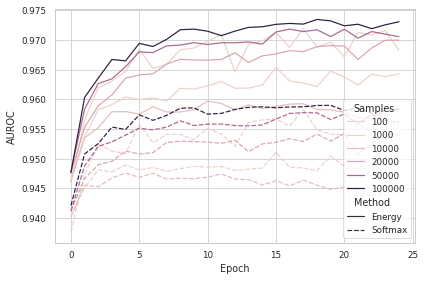

In [76]:
tmp = pd.DataFrame(metrics_l)
tmp["Samples"] = tmp["Length"]
tmp = tmp.groupby(["Epoch", "Samples", "Method"]).mean()

sb.lineplot(data=tmp,  x="Epoch", y="AUROC", hue="Samples", style="Method") 
plt.tight_layout()
plt.savefig("img/size-vs-auroc-c10.png", dpi=300)
plt.savefig("img/size-vs-auroc-c10.pgf", dpi=300)

In [75]:
tmp

AUROC   AUPR-IN  AUPR-OUT  ACC95TPR  FPR95TPR
Epoch Length Method                                                   
0     100    Energy   0.946828  0.922508  0.956816  0.849031   0.22144
             Softmax  0.940465  0.911349  0.955522  0.856581   0.21710
      1000   Energy   0.946056  0.924309  0.954898  0.843199   0.23214
             Softmax  0.937674  0.909286  0.952436  0.849615   0.22946
      10000  Energy   0.946171  0.921910  0.956141  0.847518   0.22406
...                        ...       ...       ...       ...       ...
24    20000  Softmax  0.953962  0.933648  0.966294  0.884893   0.16690
      50000  Energy   0.970520  0.960853  0.975607  0.895245   0.13848
             Softmax  0.956132  0.937138  0.967766  0.887101   0.16220
      100000 Energy   0.973043  0.964035  0.977863  0.902892   0.12512
             Softmax  0.958359  0.940041  0.969523  0.890674   0.15574

[300 rows x 5 columns]